# Lanet (v1.2): Early Stopping

In [0]:
import numpy as np 
import pandas as pd
from sklearn import metrics

def loss(y_true, y_predicted, loss_function='mse'):
    if loss_function == 'mse':       
        return metrics.mean_squared_error( y_true, y_predicted)
    else:
        raise Exception('Loss metric is not defined.')

def get_dz_from_loss(y, y_predicted, metric):
    if metric == 'mse':
        return y_predicted - y
    else:
        raise Exception('Loss metric is not defined.')

def sigma(z, act_func):
    global _activation
    if act_func == 'relu':
       return np.maximum(z, np.zeros(z.shape))
    
    elif act_func == 'sigmoid':
      return 1.0/(1.0 + np.exp( -z ))

    elif act_func == 'linear':
        return z
    else:
        raise Exception('Activation function is not defined.')

def sigma_prime(z, act_func):
    if act_func == 'relu':
        return np.maximum(np.sign(z), np.zeros(z.shape)) # 1 if backward input >0, 0 otherwise; then diaganolize

    elif act_func == 'sigmoid':
        h = sigma(z, 'sigmoid')
        return h *(1-h)

    elif act_func == 'linear':
        return np.ones(z.shape)

    else:
        raise Exception('Activation function is not defined.')

class Layer:
    def __init__(self,input_dim, output_dim, activation_function='linear'):    
        self.activation = activation_function
        self.input_dim = input_dim
        self.output_dim = output_dim 
        if input_dim > 0:
            self.b = np.random.randn( output_dim, 1 )       
            self.W = np.random.randn( output_dim, input_dim )
            self.dW = np.random.randn( output_dim, input_dim )
            self.db = np.random.randn( output_dim, 1 )
        self.a = np.zeros( (output_dim,1) )

    
    def set_weight(self, W ):
        self.W = W
      
    def set_bias(self, b ):
        self.b = b
  
    def compute_activation(self, a ): 
        self.z =  np.add( np.dot(self.W, a), self.b)
        self.a =  sigma(self.z, self.activation)
    
    
    def print( self ):      
        print(f"\n====== Layer Info =======")
        print(f"a    = {self.a}")
        if self.input_dim > 0: 
          print(f"W   =  {self.W}")          
          print(f"b   =  {self.b}")  
    

class Model:
    def __init__(self, input_dim):  
        self.neural_net = []
        self.neural_net.append(Layer(0 , input_dim, 'irrelevant'))    
        self.history = []  
 
          
    def fit(self, training_data, epochs, learning_rate=0.001, early_stop = -1, verbose=1 ):
          self.learning_rate = learning_rate
          
          X_train, y_train = training_data
          num_train_datum = X_train.shape[1]

          print(f"\n\nStart training for following parameters :")
          print(f" N              =  {num_train_datum}")
          print(f" Shape of X     =  {X_train.shape}")
          print(f" Shape of y     =  {y_train.shape}")
          print(f" epochs         = {epochs}")
          print(f" learning_rate  =  {learning_rate}")
    
          
          # Training Loop
          for epoch in range(1,epochs+1):        
              y_train_predicted = model.forward_propagation( X_train )
              self.backward_propagation( y_train, y_train_predicted, num_train_datum, verbose = verbose - 1 )
              self.update( learning_rate )
                            
              ##  - Backpropagation for whole training set is finished
              
              # After backpropagation
              # ... calculate the training loss
              y_train_predicted = model.forward_propagation( X_train )
              training_loss   = loss(y_train, y_train_predicted)
                            
              # ... add result to the histoty
              self.history.append( [epoch, training_loss])

              # ...and finally check, if early_stop applies
              if (epoch > 10)  and (early_stop > 0):            
                past_loss   = self.history[epoch-6][1] 
                if (abs(training_loss - past_loss)) < early_stop:
                  print(f"Early stop in after epoch {epoch} with training-loss  {training_loss}")
                  print(f"   Prev Loss ({epoch-5}) : {past_loss} [Delta: { abs(training_loss-past_loss) }]")
                  break  
                  # If requested, print result of this round
                  if (verbose > 0):
                    print(f"Epoch {epoch}: Train.-Loss   = { training_loss  }")

          ##### end of training loop 
          return training_loss


    def add_layer(self, nr_neurons, activation='relu'):    
        layer_index = len(self.neural_net)
        input_dim = self.neural_net[layer_index - 1].output_dim
        new_layer = Layer( input_dim, nr_neurons, activation)
        self.neural_net.append( new_layer )


    def forward_propagation(self, input_vec ):
        self.neural_net[0].a = input_vec
        for layer_index in range(1,len(self.neural_net)):    
            _A_Prev = self.neural_net[layer_index-1].a                       
            self.neural_net[layer_index].compute_activation( _A_Prev )
        return  self.neural_net[layer_index].a
  
    def backward_propagation(self, y, y_predicted, num_train_datum, metric='mse', verbose=0):   
            nr_layers = len(self.neural_net)
            for layer_index in range(nr_layers-1,0,-1):
                if layer_index+1 == nr_layers: # if output layer

                    dz = np.multiply(get_dz_from_loss(y, y_predicted, metric), 
                                    sigma_prime(
                                        self.neural_net[layer_index].a, 
                                        self.neural_net[layer_index].activation)
                    )        
                else: 
                    dz = np.multiply(
                          np.dot(
                              self.neural_net[layer_index+1].W.T, 
                              dz), 
                          sigma_prime(
                                self.neural_net[layer_index].a, 
                                self.neural_net[layer_index].activation)
                          )         
                dW = np.dot(dz, self.neural_net[layer_index-1].a.T) / num_train_datum
                db = np.sum(dz, axis=1, keepdims=True) / num_train_datum

                # Update gradients
                self.neural_net[layer_index].dW = dW 
                self.neural_net[layer_index].db = db 

                if (verbose > 0):
                  print(f"\n\n====== Backward Propagation Layer {layer_index} =======")
                  print(f"dZ      =  {dz}")          
                  print(f"dW      =  {dW}")
                  print(f"db      =  {db}")
                  print(f"A           = {self.neural_net[layer_index].a}") 
                  print(f"A prev lay  = {self.neural_net[layer_index-1].a}") 
                  

    def update( self, learning_rate ):
        nr_layers = len(self.neural_net)
        for layer_index in range(1,nr_layers):        
            self.neural_net[layer_index].set_weight( self.neural_net[layer_index].W - learning_rate * self.neural_net[layer_index].dW )
            self.neural_net[layer_index].set_bias(  self.neural_net[layer_index].b  - learning_rate * self.neural_net[layer_index].db  )
    

    def get_history(self):
            return pd.DataFrame(
                self.history, 
                columns=['epoch', 'training_loss']
            )   

    def summary(self):
        print("MODEL SUMMARY")
        for layer_index in range(len(self.neural_net)):        
          self.neural_net[layer_index].print()
          
        print("FINISHED MODEL SUMMARY")

# Test

(1, 10)


Start training for following parameters :
 N              =  10
 Shape of X     =  (2, 10)
 Shape of y     =  (1, 10)
 epochs         = 5000
 learning_rate  =  0.0007
Early stop in after epoch 11 with training-loss  0.23279324552631403
   Prev Loss (6) : 0.2798031577286295 [Delta: 0.047009912202315485]


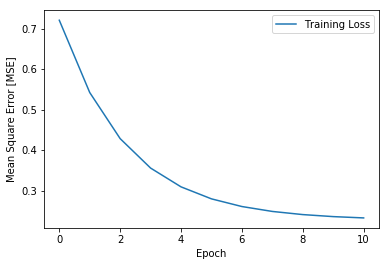

In [0]:
# Add dataloader
import matplotlib.pyplot as plt

def load_random_data_D (N = 100, delta=0.1):
    """ This can be run with just one (output) layer. 
    Set N= 5000, learning_rate=0.005, no autostop
    """
    X = np.arange(1,2*N+1).reshape(N,2) + delta*np.random.rand(N,2)
    x1 = X[:,0]
    x2 = X[:,1]    
    y = np.array([x1 + x2]); 
    print( y.shape )
    return (X, y.T)

#Test        
input_dim = 2
output_dim = 1
model = Model( input_dim )
#model.addLayer( 2, 'relu' )
model.add_layer( output_dim, 'linear' )

(X,y) = load_random_data_D( N=10, delta = 0)
model.fit( (X.T, y.T) , 5000,  learning_rate = 0.0007, early_stop = 1, verbose=0)

history = model.get_history()
plt.figure()
plt.plot(history['training_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [MSE]')
#plt.ylim([0,0.2])  
plt.legend()
plt.show()



# Analyze Gradient Explosion (to be completed)